## Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score, classification_report, confusion_matrix

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score 
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.ensemble import AdaBoostClassifier

import warnings
warnings.simplefilter(action = 'ignore', category= FutureWarning)


## Load the Dataset

In [4]:
data = pd.read_csv("dataset.csv", encoding='ANSI')
data.columns
data.head()

,id,created_at,date,time,timezone,user_id,username,name,tweet,hashtags,link,sentiment,depression_score
0,1.110000e+18,1.550000e+12,3/12/2019,14:11:05,India Standard Time,3.354696e+09,emergenciainter,Alerta Desaparecidos y Emergencias Internacion...,I've just posted a new blog: RED alert: Cyclon...,[],https://twitter.com/emergenciainter/status/110...,0,0.0
1,1.110000e+18,1.550000e+12,3/12/2019,14:10:56,India Standard Time,4.488783e+08,eviedegraef,Evie De Graef,Must see series! I cried my eyes out while bin...,"['#afterlife', '#sublime', '#sad', '#hope', '#...",https://twitter.com/eviedegraef/status/1105388...,0,0.0
2,1.110000e+18,1.550000e+12,3/12/2019,14:10:54,India Standard Time,6.488454e+07,fuckphenty,j,Depression is really getting on my nerves. I a...,[],https://twitter.com/fuckphenty/status/11053881...,1,0.8
3,1.110000e+18,1.550000e+12,3/12/2019,14:10:53,India Standard Time,8.393690e+08,gawabrfc,Russell Adams,dealing with the debts of depression and tryin...,[],https://twitter.com/GAWABRFC/status/1105388176...,1,0.5
4,1.110000e+18,1.550000e+12,3/12/2019,14:10:50,India Standard Time,4.835700e+09,owo_doodles,gay demon,i have depression,[],https://twitter.com/owo_doodles/status/1105388...,1,0.5


In [5]:
data = data.drop(['id',
       'created_at', 'date', 'time',
       'timezone', 'user_id', 'username',
       'name', 'hashtags','link'],axis=1)
data.head(10)

,tweet,sentiment,depression_score
0,I've just posted a new blog: RED alert: Cyclon...,0,0.0
1,Must see series! I cried my eyes out while bin...,0,0.0
2,Depression is really getting on my nerves. I a...,1,0.8
3,dealing with the debts of depression and tryin...,1,0.5
4,i have depression,1,0.5
5,True struggles: -being lonely and also anti-so...,1,0.5
6,help me please. M dying with Depression.,1,0.8
7,cant wait to go home and take a fat ass depres...,1,0.3
8,Depression is the least of my worries. I don’t...,0,0.0
9,fuckin petas got me stressed out. i also gotta...,1,0.3


In [6]:
# check the number of negative and non-negative sentences

non_negatives = data['sentiment'][data.sentiment == 0]
negatives = data['sentiment'][data.sentiment == 1]

print('number of non-negative sentences is:  {}'.format(len(non_negatives)))
print('number of negative tagged sentences is: {}'.format(len(negatives)))
print('total length of the data is:            {}'.format(data.shape[0]))


number of non-negative sentences is:  790
number of negative tagged sentences is: 710
total length of the data is:            1500


In [7]:
# Depression level
data['depression_level'] = data['depression_score'].apply(lambda x: 'No depression' if x == 0 else('Minimal depression' if 0 < x <= 0.2 else('Mild depression' if 0.3 <= x <= 0.55 else('Moderate depression' if 0.6 <= x <= 0.7 else 'Severe depression'))))
print (data)

# get a word count per sentence column
def word_count(sentence):
    return len(sentence.split())
    
data['word count'] = data['tweet'].apply(word_count)
data.head()

                                                  tweet  sentiment  \
0     I've just posted a new blog: RED alert: Cyclon...          0   
1     Must see series! I cried my eyes out while bin...          0   
2     Depression is really getting on my nerves. I a...          1   
3     dealing with the debts of depression and tryin...          1   
4                                     i have depression          1   
...                                                 ...        ...   
1495  E-Cigarettes Linked to Heart Attacks, Coronary...          0   
1496                                         Depression          1   
1497  Sadly I do see myself as a failure, and have b...          1   
1498  #SpiderManPS4 WebSwing the City Through Anxiet...          0   
1499  im dying from depression. I feel terrible. Thi...          1   

      depression_score     depression_level  
0                  0.0        No depression  
1                  0.0        No depression  
2                  0.

,tweet,sentiment,depression_score,depression_level,word count
0,I've just posted a new blog: RED alert: Cyclon...,0,0.0,No depression,22
1,Must see series! I cried my eyes out while bin...,0,0.0,No depression,17
2,Depression is really getting on my nerves. I a...,1,0.8,Severe depression,37
3,dealing with the debts of depression and tryin...,1,0.5,Mild depression,15
4,i have depression,1,0.5,Mild depression,3


## Data Cleaning

In [8]:
# helper function to clean tweets
import re
import string

def processTweet(tweet):
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove
    tweet = re.sub(r'\€\w*','', tweet)
    tweet = re.sub(r'\€™\w*','', tweet)
    tweet = re.sub(r'\â€¦\w*','', tweet)
    tweet = re.sub(r'\€¦\w*','', tweet)
    tweet = re.sub(r'\¦\w*','', tweet)
    tweet = re.sub(r'\™\w*','', tweet)
    
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet
# ______________________________________________________________
# clean dataframe's text column
data['text'] = data['tweet'].apply(processTweet)
# preview some cleaned tweets
data['text'].head()


0    ' just posted new blog: red alert: cyclone ida...
1    must see series! cried eyes out while bingewat...
2    depression really getting nerves. having diffi...
3    dealing with the debts depression and trying g...
4                                      have depression
Name: text, dtype: object

# Tokenization

In [9]:
# tokenize helper function
def text_process(raw_text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in list(raw_text) if char not in string.punctuation]
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.lower().split() if word.lower() not in stopwords.words('english')]

def remove_words(word_list):
    remove = ['...','“','”','’','…','€™','itâ€™','itâ™']
    return [w for w in word_list if w not in remove]
# -------------------------------------------
# tokenize message column and create a column for tokens
data = data.copy()
data['tokens'] = data['text'].apply(text_process) 
data.head()

,tweet,sentiment,depression_score,depression_level,word count,text,tokens
0,I've just posted a new blog: RED alert: Cyclon...,0,0.0,No depression,22,' just posted new blog: red alert: cyclone ida...,"[posted, new, blog, red, alert, cyclone, idai,..."
1,Must see series! I cried my eyes out while bin...,0,0.0,No depression,17,must see series! cried eyes out while bingewat...,"[must, see, series, cried, eyes, bingewatching]"
2,Depression is really getting on my nerves. I a...,1,0.8,Severe depression,37,depression really getting nerves. having diffi...,"[depression, really, getting, nerves, difficul..."
3,dealing with the debts of depression and tryin...,1,0.5,Mild depression,15,dealing with the debts depression and trying g...,"[dealing, debts, depression, trying, get, back]"
4,i have depression,1,0.5,Mild depression,3,have depression,[depression]


## Exploratory Data Analysis

In [10]:
# split sentences to get individual words
all_words = []
for line in data['tokens']:
    all_words.extend(line)
    
    for word in words:
        all_words.append(word.lower())

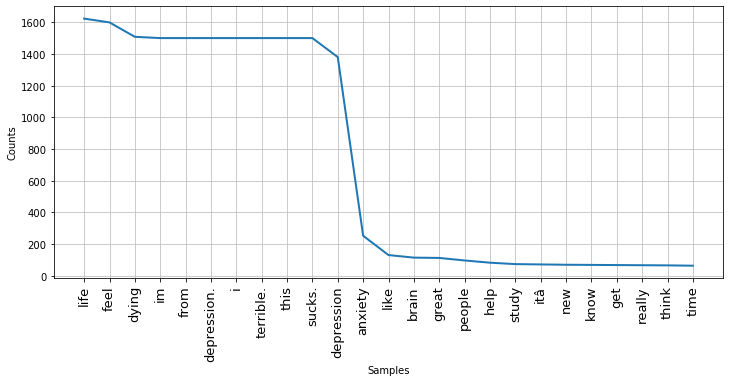

In [11]:
# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)


Text(0.5, 1.0, 'log-log plot of words frequency')

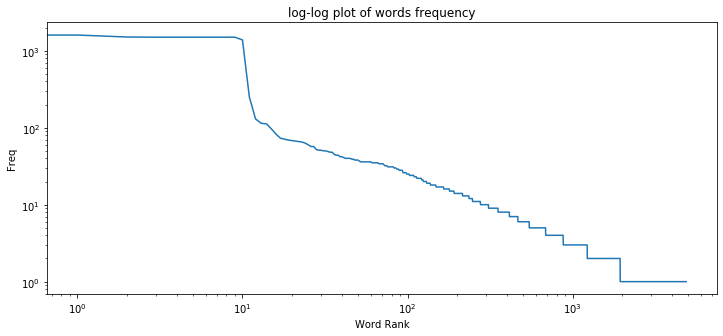

In [12]:
# log-log of all words
word_counts = sorted(Counter(all_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")
plt.title('log-log plot of words frequency')

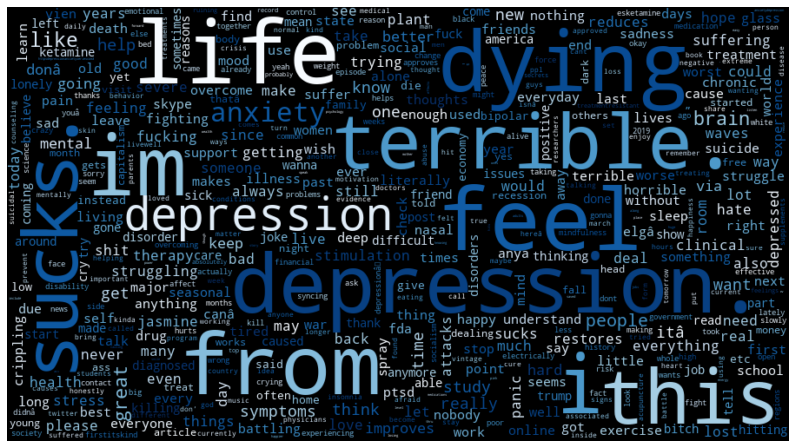

In [13]:
# create a word frequency dictionary
wordfreq = Counter(all_words)
# draw a Word Cloud with word frequencies
from wordcloud import WordCloud,STOPWORDS
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(14,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


## Bag of Words Model

In [14]:
#VECTORIZATION
# vectorize
bow_transformer = CountVectorizer(analyzer=text_process).fit(data['text'])
# print total number of vocab words
print(len(bow_transformer.vocabulary_))


4878


In [15]:
# transform the entire DataFrame of texts
text_bow = bow_transformer.transform(data['text'])
# check out the bag-of-words counts for the entire corpus as a large sparse matrix
print('Shape of Sparse Matrix: ', text_bow.shape)
print('Amount of Non-Zero occurences: ', text_bow.nnz)


Shape of Sparse Matrix:  (1500, 4878)
Amount of Non-Zero occurences:  16638


In [16]:
tfidf_transformer = TfidfTransformer().fit(text_bow)

# to transform the entire bag-of-words corpus
text_tfidf = tfidf_transformer.transform(text_bow)
print(text_tfidf.shape)


(1500, 4878)


## Train-Test Split 

In [17]:
# We split the data into training and testing set:
train, test = train_test_split(data, test_size=0.3, random_state=1)
X_train = train['tweet'].values
X_test = test['tweet'].values
y_train = train['sentiment']
y_test = test['sentiment']

## Adaptive Boosting Classifier

## Training and Predicting

In [26]:
# We are going to use cross validation and grid search to find good hyperparameters for our model. We need to build a pipeline to don't get features from the validation folds when building each training model.
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
np.random.seed(1)

pipeline = Pipeline([
    ('bow', CountVectorizer(strip_accents='ascii',
                            stop_words='english',
                            lowercase=True)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', AdaBoostClassifier(n_estimators=500)),  
])
# this is where we define the values for GridSearchCV to iterate over
parameters = {'bow__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
             }
# k-fold cross validation
Ada_boost = GridSearchCV(pipeline, cv=kfolds, param_grid=parameters, verbose=1)
Ada_boost.fit(X_train,y_train)
Ada_boost.score(X_test, y_test)

print("\nBest Model: %f using %s" % (Ada_boost.best_score_, Ada_boost.best_params_))
print('\n')
means = Ada_boost.cv_results_['mean_test_score']
stds = Ada_boost.cv_results_['std_test_score']
params = Ada_boost.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean: %f Stdev:(%f) with: %r" % (mean, stdev, param))

# save best model to current working directory
joblib.dump(Ada_boost, "twitter_sentiment.pkl")

# load from file and predict using the best configs found in the CV step
model_Ada_boost = joblib.load("twitter_sentiment.pkl" )

# get predictions from best model above
y_adaboost_preds = model_Ada_boost.predict(X_test)
print('Ada_boost_accuracy score: ',accuracy_score(y_test, y_adaboost_preds))
print('\n')

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.3min finished



Best Model: 0.824762 using {'bow__ngram_range': (1, 1), 'tfidf__use_idf': False}


Mean: 0.805714 Stdev:(0.023203) with: {'bow__ngram_range': (1, 1), 'tfidf__use_idf': True}
Mean: 0.824762 Stdev:(0.026441) with: {'bow__ngram_range': (1, 1), 'tfidf__use_idf': False}
Mean: 0.791429 Stdev:(0.031318) with: {'bow__ngram_range': (1, 2), 'tfidf__use_idf': True}
Mean: 0.800000 Stdev:(0.027945) with: {'bow__ngram_range': (1, 2), 'tfidf__use_idf': False}
Ada_boost_accuracy score:  0.8622222222222222




## Evaluation

In [28]:
print(confusion_matrix(y_test, y_adaboost_preds))
print('\n')
print(classification_report(y_test, y_adaboost_preds))

[[197  36]
 [ 26 191]]


              precision    recall  f1-score   support

           0       0.88      0.85      0.86       233
           1       0.84      0.88      0.86       217

    accuracy                           0.86       450
   macro avg       0.86      0.86      0.86       450
weighted avg       0.86      0.86      0.86       450



## Gradient Boosting Classifier

## Training and Predicting

In [29]:
from sklearn.ensemble import GradientBoostingClassifier
# We are going to use cross validation and grid search to find good hyperparameters for our model. We need to build a pipeline to don't get features from the validation folds when building each training model.
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
np.random.seed(1)

pipeline = Pipeline([
    ('bow', CountVectorizer(strip_accents='ascii',
                            stop_words='english',
                            lowercase=True)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', GradientBoostingClassifier(n_estimators=500, learning_rate=1.0, max_depth=1)),  
])
# this is where we define the values for GridSearchCV to iterate over
parameters = {'bow__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
             }
# k-fold cross validation
Gradient_boosting = GridSearchCV(pipeline, cv=kfolds, param_grid=parameters, verbose=1)
Gradient_boosting.fit(X_train,y_train)
Gradient_boosting.score(X_test, y_test)

print("\nBest Model: %f using %s" % (Gradient_boosting.best_score_, Gradient_boosting.best_params_))
print('\n')
means = Gradient_boosting.cv_results_['mean_test_score']
stds = Gradient_boosting.cv_results_['std_test_score']
params = Gradient_boosting.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean: %f Stdev:(%f) with: %r" % (mean, stdev, param))

# save best model to current working directory
joblib.dump(Gradient_boosting, "twitter_sentiment.pkl")

# load from file and predict using the best configs found in the CV step
model_Gradient_boosting = joblib.load("twitter_sentiment.pkl" )

# get predictions from best model above
y_gradientboost_preds = model_Gradient_boosting.predict(X_test)
print('Gradient_boosting_accuracy score: ',accuracy_score(y_test, y_gradientboost_preds))
print('\n')


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   50.0s finished



Best Model: 0.837143 using {'bow__ngram_range': (1, 1), 'tfidf__use_idf': False}


Mean: 0.836190 Stdev:(0.029391) with: {'bow__ngram_range': (1, 1), 'tfidf__use_idf': True}
Mean: 0.837143 Stdev:(0.030750) with: {'bow__ngram_range': (1, 1), 'tfidf__use_idf': False}
Mean: 0.831429 Stdev:(0.020121) with: {'bow__ngram_range': (1, 2), 'tfidf__use_idf': True}
Mean: 0.821905 Stdev:(0.020038) with: {'bow__ngram_range': (1, 2), 'tfidf__use_idf': False}
Gradient_boosting_accuracy score:  0.8666666666666667




## Evaluation

In [30]:
print(confusion_matrix(y_test, y_gradientboost_preds))
print('\n')
print(classification_report(y_test, y_gradientboost_preds))

[[188  45]
 [ 15 202]]


              precision    recall  f1-score   support

           0       0.93      0.81      0.86       233
           1       0.82      0.93      0.87       217

    accuracy                           0.87       450
   macro avg       0.87      0.87      0.87       450
weighted avg       0.87      0.87      0.87       450



## XGBoost Classifier

## Training and Predicting

In [31]:
import xgboost as xgb
from xgboost import XGBClassifier
# We are going to use cross validation and grid search to find good hyperparameters for our model. We need to build a pipeline to don't get features from the validation folds when building each training model.
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
np.random.seed(1)

pipeline = Pipeline([
    ('bow', CountVectorizer(strip_accents='ascii',
                            stop_words='english',
                            lowercase=True)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5,
                        min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                        objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)),  
])
# this is where we define the values for GridSearchCV to iterate over
parameters = {'bow__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
             }
# k-fold cross validation
xgboost = GridSearchCV(pipeline, cv=kfolds, param_grid=parameters, verbose=1)
xgboost.fit(X_train,y_train)
xgboost.score(X_test, y_test)

print("\nBest Model: %f using %s" % (xgboost.best_score_, xgboost.best_params_))
print('\n')
means = xgboost.cv_results_['mean_test_score']
stds = xgboost.cv_results_['std_test_score']
params = xgboost.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean: %f Stdev:(%f) with: %r" % (mean, stdev, param))

# save best model to current working directory
joblib.dump(xgboost, "twitter_sentiment.pkl")

# load from file and predict using the best configs found in the CV step
model_xgboost = joblib.load("twitter_sentiment.pkl" )

# get predictions from best model above
y_xgboost_preds = model_xgboost.predict(X_test)
print('xgboost_accuracy score: ',accuracy_score(y_test, y_xgboost_preds))
print('\n')


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.9min finished



Best Model: 0.818095 using {'bow__ngram_range': (1, 1), 'tfidf__use_idf': False}


Mean: 0.817143 Stdev:(0.022248) with: {'bow__ngram_range': (1, 1), 'tfidf__use_idf': True}
Mean: 0.818095 Stdev:(0.026698) with: {'bow__ngram_range': (1, 1), 'tfidf__use_idf': False}
Mean: 0.787619 Stdev:(0.022382) with: {'bow__ngram_range': (1, 2), 'tfidf__use_idf': True}
Mean: 0.807619 Stdev:(0.023123) with: {'bow__ngram_range': (1, 2), 'tfidf__use_idf': False}
xgboost_accuracy score:  0.8622222222222222




## Evaluation

In [32]:
print(confusion_matrix(y_test, y_xgboost_preds))
print('\n')
print(classification_report(y_test, y_xgboost_preds))

[[188  45]
 [ 17 200]]


              precision    recall  f1-score   support

           0       0.92      0.81      0.86       233
           1       0.82      0.92      0.87       217

    accuracy                           0.86       450
   macro avg       0.87      0.86      0.86       450
weighted avg       0.87      0.86      0.86       450

